In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sever.data_loader import RLE

In [2]:
pseudo_csv = '../data/raw/severstal-steel-defect-detection/pseudo.csv'
df = pd.read_csv(pseudo_csv)
df.head(20)

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,NaN
1,004f40c73.jpg_2,NaN
2,004f40c73.jpg_3,NaN
3,004f40c73.jpg_4,NaN
4,006f39c41.jpg_1,NaN
5,006f39c41.jpg_2,NaN
6,006f39c41.jpg_3,NaN
7,006f39c41.jpg_4,NaN
8,00b7fb703.jpg_1,NaN
9,00b7fb703.jpg_2,NaN


In [3]:
df['ImageId'], df['ClassId'] = zip(*df['ImageId_ClassId'].str.split('_'))
df['ClassId'] = df['ClassId'].astype(int)
df = df.pivot(index='ImageId', columns='ClassId', values='EncodedPixels')
df.columns = [f'rle{c}' for c in range(4)]
df['defects'] = df.count(axis=1)
for c in range(4):
    df[f'c{c}'] = df[f'rle{c}'].apply(lambda rle: not pd.isnull(rle))

In [4]:
df.head()

,rle0,rle1,rle2,rle3,defects,c0,c1,c2,c3
ImageId,,,,,,,,,
004f40c73.jpg,NaN,NaN,NaN,NaN,0,False,False,False,False
006f39c41.jpg,NaN,NaN,NaN,NaN,0,False,False,False,False
00b7fb703.jpg,NaN,NaN,NaN,NaN,0,False,False,False,False
00bbcd9af.jpg,NaN,NaN,155553 65 155741 161 155984 177 156228 189 156...,298435 16 298689 28 298944 35 299199 40 299454...,2,False,False,True,True
0108ce457.jpg,NaN,NaN,NaN,NaN,0,False,False,False,False


In [5]:
counts = {c: df[f'c{c}'].sum() for c in range(4)}
counts  # approx same distribution as train except for class 1 (almost zero of these)

{0: 92, 1: 1, 2: 579, 3: 110}

In [20]:
img_dir = Path('../data/raw/severstal-steel-defect-detection/test_images')
img_filenames = list(img_dir.glob('*.jpg'))
len(img_filenames)

1801

In [62]:
start_idx = np.random.randint(0, len(img_filenames) - 3)
end_idx = start_idx + 3
imgs = [cv2.imread(str(f))[:, :, 0] for f in img_filenames[start_idx:end_idx]]
rles = [df.loc[f.name, ['rle0', 'rle1', 'rle2', 'rle3']] for f in img_filenames[start_idx:end_idx]]
masks = [np.stack([RLE.from_str(s).to_mask() for s in row], axis=2) for row in rles]

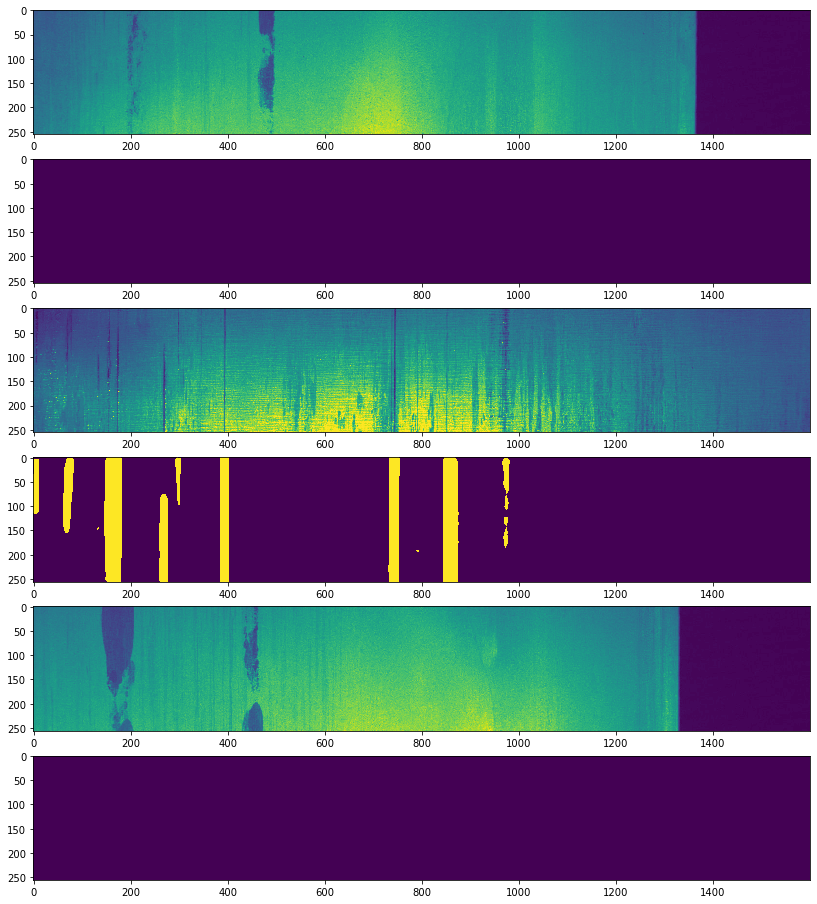

In [63]:
def plot_imgs(imgs, masks):
    fig, axs = plt.subplots(6, 1, figsize=(16, 16))
    for i in range(3):
        axs[i*2].imshow(imgs[i])
        axs[i*2+1].imshow(masks[i].sum(axis=2))
    plt.show()
plot_imgs(imgs, masks)